In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import numpy as np
import sys
sys.path.append('../Utilities')
sys.path.append('../ControllersObject')
sys.path.append('../')

import LMPC
import SysModel
from trackInitialization import Map
import utilities
import pwa_cluster as pwac

import matplotlib.pyplot as plt

In [29]:
trackMap = Map('3110_big') 
dt = 0.1
n = 6; d = 2
state_names = ['vx', 'vy', 'wz', 'epsi', 's', 'ey']

affine = False
dim0 = n+d+1 if affine else n+d
# mask = [A B d].T
sparse_mask = np.ones([n, dim0])
sparse_mask[0:3, 3:6] = 0
sparse_mask[0,6] = 0
sparse_mask[1:3,7] = 0
sparse_mask[3:,6:8] = 0
sparse_mask = sparse_mask.T

n_data = 1000

In [30]:
def generate_random_input():
    # x = [vx, vy, wz, epsi, s, ey]
    # u = [delta, a]
    # NOTE:
    # vx: 0.5 to 2.5/3
    # vy: -1, 1
    # wz: -1, 1
    # espi: -1, 1
    x = np.random.uniform(size=[n]) * np.array([2, 2, 2, 2, 1.25 * trackMap.TrackLength, 2*0.8]) + np.array([0.5, -1, -1, -1, 0, -0.8])
    u = np.random.uniform(size=[d]) * np.array([1, 2]) + np.array([-0.5, -1])
    return x, u

def get_z_y_pair():
    x, u = generate_random_input()
    x_glob = trackMap.get_global_state(x)
    x_next, x_glob_next = SysModel._DynModel(x, x_glob, u, dt, trackMap.PointAndTangent)
    return np.hstack([x,u]), x_next


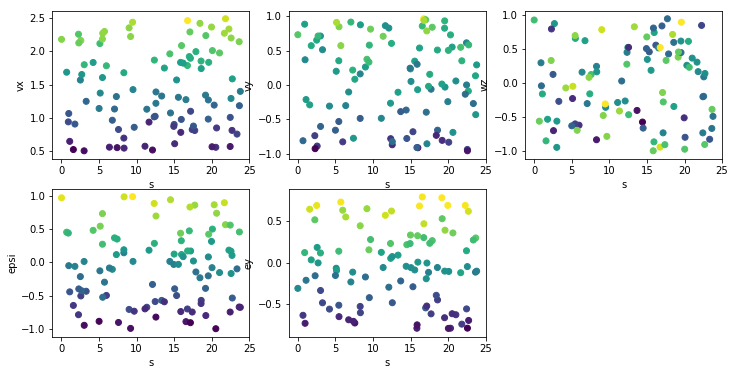

In [31]:
zs = []; ys = []
for i in range(n_data):
    z, y = get_z_y_pair()
    zs.append(z); ys.append(y)

zs = np.array(zs)
ys = np.array(ys)
    
plt.figure(figsize=[12,6])

for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(zs[::10,4], zs[::10,ind], c=ys[::10,ind])
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind])

In [32]:
if True:
    best_clustering = pwac.ClusterPWA.from_num_clusters(zs, ys, 10, z_cutoff=n, affine=affine, sparse_mask=sparse_mask)
    best_clustering.fit_clusters(verbose=True)
else:
    nc_list = [1,4,6,10]
    best_clustering, ind_perm = pwac.select_nc_cross_validation(nc_list, zs, ys, verbose=True, z_cutoff=n, affine=True)


assigning datapoints to clusters
updating models
centroid movement 4.19551398143
assigning datapoints to clusters
updating models
centroid movement 0.800167347543
assigning datapoints to clusters
updating models
centroid movement 0.429181801927
assigning datapoints to clusters
updating models
centroid movement 0.257309317866
assigning datapoints to clusters
updating models
centroid movement 0.144642148562
assigning datapoints to clusters
updating models
centroid movement 0.18348572674
assigning datapoints to clusters
updating models
centroid movement 0.179117206538
assigning datapoints to clusters
updating models
centroid movement 0.122748781523
assigning datapoints to clusters
updating models
centroid movement 0.0715059022821
assigning datapoints to clusters
updating models
centroid movement 0.0733507431358
assigning datapoints to clusters
updating models
centroid movement 0.0993260964632
assigning datapoints to clusters
updating models
centroid movement 0.14272612241
assigning datapo

In [33]:
best_clustering.Nc

10

In [34]:
pwac.print_PWA_models(pwac.get_PWA_models(best_clustering.thetas, n, d))

[[ 0.98 -0.02  0.    0.    0.    0.     nan  0.    0.1    nan  0.1 ]
 [ 0.    0.33 -0.07  0.    0.    0.     nan  0.18  0.     nan  0.  ]
 [ 0.01  0.21  0.38  0.    0.    0.     nan  4.54  0.     nan  0.  ]
 [ 0.04  0.01  0.04  1.   -0.   -0.01   nan  0.    0.     nan  0.  ]
 [ 0.1  -0.01  0.01 -0.02  1.   -0.03   nan  0.    0.     nan  0.  ]
 [ 0.01  0.05 -0.    0.15 -0.    1.     nan  0.    0.     nan  0.  ]]
[[ 0.97 -0.01  0.01  0.    0.    0.     nan  0.    0.1    nan  0.1 ]
 [ 0.01  0.27 -0.04  0.    0.    0.     nan  0.27  0.     nan  0.  ]
 [-0.02  0.34  0.15  0.    0.    0.     nan  3.97  0.     nan  0.  ]
 [ 0.04  0.01  0.03  0.99  0.   -0.05   nan  0.    0.     nan  0.  ]
 [ 0.09 -0.02  0.   -0.02  1.   -0.09   nan  0.    0.     nan  0.  ]
 [-0.    0.05 -0.    0.13  0.    1.     nan  0.    0.     nan  0.  ]]
[[ 0.98  0.04  0.    0.    0.    0.     nan  0.    0.12   nan  0.12]
 [-0.    0.25 -0.05  0.    0.    0.     nan  0.24  0.     nan  0.  ]
 [ 0.01  0.38  0.32  0.    0.   

In [35]:
best_clustering.determine_polytopic_regions(verbose=True)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 144000, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 9070, constraints m = 18000
Cones:	linear vars: 18000
Setup time: 5.44e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.91e+00  7.99e+00  9.84e-01 -2.07e+01  3.90e+01  0.00e+00  3.21e-02 
   100| 1.85e-01  3.44e-01  3.09e-02  6.91e+00  7.38e+00  1.35e-15  8.21e-01 
   200| 1.03e-01  2.13e-01  6.27e-02  1.61e+00  1.89e+00  1.19e-15  1.64e+00 
   300| 6.60e-02  8.34e-02  6.74e-02  5.60e-01  7.14e-

In [36]:
# self.clustering = pwac.ClusterPWA.from_labels(zs, ys, 
#                                data['labels'], z_cutoff=self.n)
# self.clustering.region_fns = data['region_fns']
np.savez('pwa_model_'+str(best_clustering.Nc), labels=best_clustering.cluster_labels, region_fns=best_clustering.region_fns, 
         thetas=best_clustering.thetas, zs=best_clustering.zs, ys=best_clustering.ys)

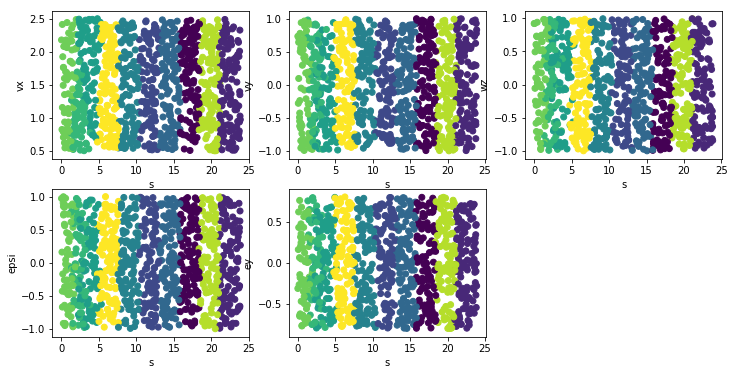

In [38]:
data = np.load('pwa_model_10.npz')
# looks like everything is in the same region here....

labels = []
for z,y in zip(zs,ys):
    dot_pdt = [w.T.dot(np.hstack([z[0:n], [1]])) for w in data['region_fns']]
    labels.append(np.argmax(dot_pdt))

plt.figure(figsize=[12,6])
for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(zs[:,4], zs[:,ind], c=labels)
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind])
# self.clustering = pwac.ClusterPWA.from_labels(zs, ys, 
#                data['labels'], z_cutoff=self.n)
# self.clustering.region_fns = data['region_fns']

In [16]:
pwac.getRegionMatrices(best_clustering.region_fns)

([array([[   5.50037982,   -1.90882199,   -3.16823685,    5.56403496,
           177.34394541,   -0.64033323],
         [   4.37602257,   -0.48930028,   -0.24263818,   -0.54014911,
           112.728199  ,   -2.77096829],
         [   9.10025457,   -2.0120832 ,   -0.92961137,   -1.83368628,
            73.62091953,    0.94754071],
         [   2.60589791,   -2.64912587,    2.43539486,   -2.14209825,
            38.79762424,    1.97082554]]),
  array([[ -5.50037982e+00,   1.90882199e+00,   3.16823685e+00,
           -5.56403496e+00,  -1.77343945e+02,   6.40333234e-01],
         [ -1.12435725e+00,   1.41952171e+00,   2.92559867e+00,
           -6.10418407e+00,  -6.46157464e+01,  -2.13063506e+00],
         [  3.59987475e+00,  -1.03261214e-01,   2.23862548e+00,
           -7.39772124e+00,  -1.03723026e+02,   1.58787395e+00],
         [ -2.89448191e+00,  -7.40303885e-01,   5.60363170e+00,
           -7.70613321e+00,  -1.38546321e+02,   2.61115878e+00]]),
  array([[  -4.37602257,    0.489300

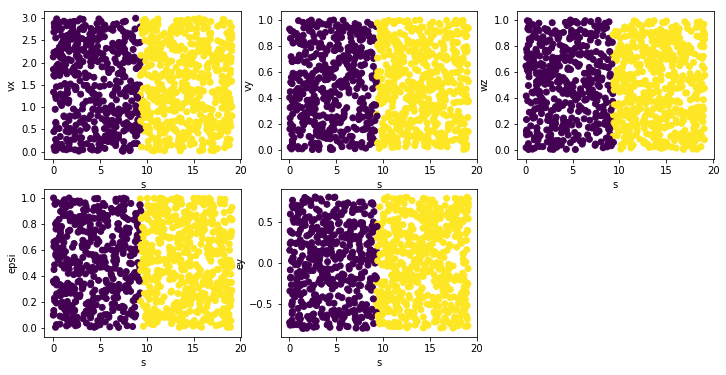

In [17]:
plt.figure(figsize=[12,6])
for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(best_clustering.zs[:,4], best_clustering.zs[:,ind], c=best_clustering.cluster_labels)
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind])

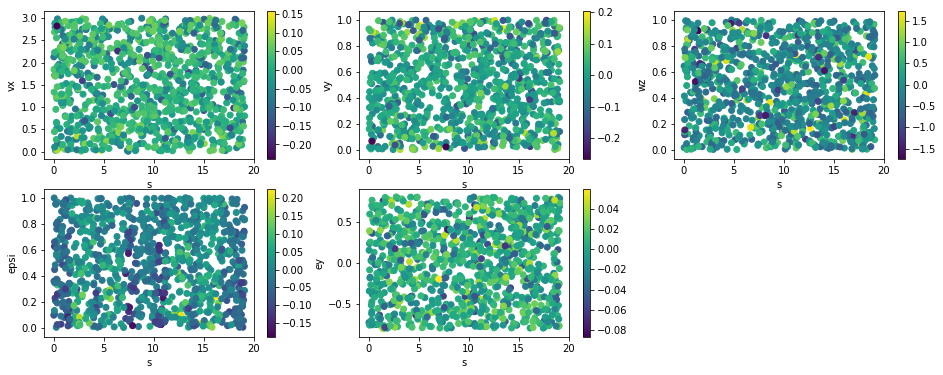

In [18]:
yhats = []
for z,y in zip(best_clustering.zs, best_clustering.ys):
    yhats.append(best_clustering.get_prediction(z))
yhats = np.array(yhats)

plt.figure(figsize=[16,6])
for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(best_clustering.zs[:,4], best_clustering.zs[:,ind], c=(best_clustering.ys[:,ind]-yhats[:,ind]))
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind]); plt.colorbar()

In [9]:
best_clustering.Nc

15

In [8]:
print(x_next)
print(x_glob_next)

[  0.40271081  -0.0565205   -0.51047363   0.06231556  11.55229491
  -0.59633254]
[ 0.40362651 -0.05722567 -0.51032248  3.10423143 -2.42395266 -3.05482882]


In [ ]:
# 10 regions (fit from sim)
[[ 0.99 -0.04 -0.03  0.02  0.    0.03   nan  0.21  0.11   nan -0.  ]
 [ 0.08  0.26 -0.03 -0.05  0.   -0.02   nan  0.24  0.02   nan -0.08]
 [-0.11  0.73 -0.05 -0.28  0.    0.31   nan  2.93  0.13   nan  0.04]
 [ 0.02  0.03  0.02  1.   -0.   -0.03   nan  0.16  0.02   nan  0.  ]
 [ 0.08  0.02 -0.   -0.07  1.   -0.03   nan  0.01 -0.     nan  0.02]
 [ 0.06  0.02 -0.    0.09  0.    0.99   nan  0.03  0.02   nan -0.05]]

In [ ]:
# 2 regions (fit from sim)
[[ 0.98  0.03 -0.01  0.01  0.    0.     nan  0.07  0.1    nan -0.01]
 [ 0.06  0.22 -0.02 -0.03  0.    0.     nan  0.23  0.02   nan -0.05]
 [ 0.05  0.28  0.01 -0.02  0.    0.04   nan  2.73  0.04   nan -0.07]
 [ 0.03  0.01  0.02  1.01  0.   -0.02   nan  0.18  0.     nan  0.  ]
 [ 0.08 -0.    0.   -0.06  1.   -0.03   nan -0.01 -0.     nan  0.02]
 [ 0.05  0.03 -0.    0.08  0.    1.     nan  0.03  0.01   nan -0.04]]
[[ 0.98  0.02 -0.01 -0.   -0.   -0.     nan  0.15  0.1    nan  0.  ]
 [ 0.06  0.24 -0.04 -0.03 -0.    0.01   nan  0.18  0.01   nan -0.05]
 [ 0.07  0.1   0.07  0.07  0.01  0.08   nan  3.32  0.01   nan -0.04]
 [ 0.03  0.01  0.03  1.    0.   -0.02   nan  0.2   0.     nan  0.  ]
 [ 0.09 -0.01  0.01 -0.06  1.   -0.04   nan -0.01  0.     nan  0.02]
 [ 0.05  0.04 -0.    0.08 -0.    1.     nan  0.03  0.     nan -0.04]]


In [ ]:
# 2 (1) regions (fit from trajectory)
[[ 0.95  0.53 -0.05 -0.01 -0.    0.03   nan  0.01  0.09   nan  0.01]
 [-0.01 -0.    0.01 -0.    0.   -0.01   nan  0.25 -0.     nan  0.01]
 [-0.19 -0.94  0.15 -0.02  0.   -0.08   nan  2.41 -0.03   nan  0.12]
 [ 0.02  0.01  0.02  1.09 -0.    0.02   nan  0.18  0.01   nan  0.  ]
 [ 0.09 -0.02  0.   -0.01  1.   -0.02   nan -0.    0.     nan  0.  ]
 [ 0.01 -0.03  0.01  0.07  0.    1.     nan  0.02  0.     nan -0.  ]]
[[ 0.83  0.39 -0.05  0.02 -0.   -0.05   nan  0.04  0.09   nan  0.12]
 [-0.01 -0.12  0.02  0.   -0.   -0.     nan  0.25 -0.     nan  0.01]
 [-0.21 -2.13  0.27  0.03 -0.   -0.04   nan  2.43 -0.     nan  0.14]
 [ 0.01 -0.22  0.05  1.1  -0.    0.01   nan  0.18 -0.     nan  0.01]
 [ 0.08  0.03 -0.   -0.    1.   -0.03   nan  0.    0.     nan  0.01]
 [ 0.    0.01  0.    0.07 -0.    1.     nan  0.02  0.     nan -0.  ]]


In [26]:
best_clustering.h

AttributeError: 'ClusterPWA' object has no attribute 'h'

In [27]:
min([])

ValueError: min() arg is an empty sequence